In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [13]:
GAME_TYPE = 15
def get_content_list(content):
    content_list = []
    begin_idx = None
    lb = 0
    for idx, s in enumerate(content):
        if s == '[':
            lb += 1
            if begin_idx is None:
                begin_idx = idx
        if s == ']':
            lb -= 1
            if begin_idx is not None and lb==0:
                content_list.append(content[begin_idx:idx+1])
                begin_idx = None
    return content_list

def parse_array(s):
    
    if s.startswith('[['):
        arr = []
        array_list = get_content_list(s[1:-1])
        for a in array_list:
            arr.append(parse_array(a))
        return arr
    elif s.startswith('['):
        arr = []
        array_list = s[1:-1].split(', ')
        
        for a in array_list:
            arr.append(parse_array(a))
        return arr
    else:
        return float(s)


def extract_data(lines):
    onnx_preds = []
    prob_lists = []
    # executed = []
    result = []
    days = 0
    for line in lines:
        line = line.strip()
        if line.startswith("YUTIAN") and "result" in line:
            start_idx = line.find("[")
            res = parse_array(line[start_idx:])
            for i in range(days):
                result.append(res)
            days = 0
        # if line.startswith("YUTIAN") and "Execute" in line:
        #     start_idx = line.find("is ")
        #     end_idx = line.find("(need")
        #     executed_idx = int(line[start_idx+3:end_idx])-1
        #     for i in range(len(onnx_preds)-len(executed)):
        #         executed.append(executed_idx)
        if line.startswith("YUTIAN") and '[[' in line:
            start_idx = line.find("[[")
            if 'onnx' in line:
                days += 1
                onnx_preds.append(parse_array(line[start_idx:]))
            elif 'getProb' in line:
                prob_lists.append(parse_array(line[start_idx:]))
    return np.array(onnx_preds), np.array(prob_lists), np.array(result) #, np.array(executed)

def accuracy(input, target):
    # input B C; target B D
    # output B, C
    result = np.zeros((input.shape[0], input.shape[1]))
    for b in range(input.shape[0]):
        for c in range(input.shape[1]):
            result[b][c] = int(target[b][input[b][c]]==c)
    return result

def accuracy2(input, target):
    # input B D; target B D
    # output B C
    result = np.zeros((input.shape[0], 6 if GAME_TYPE==15 else 4))
    c_list = [[[] for i in range(6 if GAME_TYPE==15 else 4)] for j in range(input.shape[0])]
    for b in range(input.shape[0]):
        for d in range(input.shape[1]):
            c_list[b][input[b][d]].append(d)
    for b in range(input.shape[0]):
        for c in range(6 if GAME_TYPE==15 else 4):
            if len(c_list[b][c])>0:
                p = random.choice(c_list[b][c])
                result[b][c] = int(target[b][p]==c)
            else:
                result[b][c] = 0
    return result

def accuracy3(input, target):
    # input B D; target B D
    # output B C
    result = np.zeros((input.shape[0], 6 if GAME_TYPE==15 else 4))
    c_list = [[[] for i in range(6 if GAME_TYPE==15 else 4)] for j in range(input.shape[0])]
    for b in range(input.shape[0]):
        for d in range(input.shape[1]):
            c_list[b][input[b][d]].append(d)
    for b in range(input.shape[0]):
        for c in range(6 if GAME_TYPE==15 else 4):
            if len(c_list[b][c])>0:
                p = np.argmax(input[b][np.array(c_list[b][c])])
                # p = random.choice(c_list[b][c])
                result[b][c] = int(target[b][p]==c)
            else:
                result[b][c] = 0
    return result

fname = "result_yutian_15.log"
with open(fname, 'r') as f:
    lines = f.readlines()
    onnx_preds, prob_lists, result = extract_data(lines)
# print(len(onnx_preds))
result -= 1
if GAME_TYPE==15:
    # probs w, v, s, p, m, b
    # onnx v, s, m, b, w, p
    prob_lists = prob_lists[:, [1, 2, 4, 5, 0, 3], :]
onnx_rec = np.argmax(onnx_preds[:, :6, :], axis=-2) # B D
prob_rec = np.argmax(prob_lists, axis=-2)
print('onnx rec: ', np.sum(np.equal(onnx_rec, result))/(result.shape[0]*result.shape[1]))
print('prob rec: ', np.sum(np.equal(prob_rec, result))/(result.shape[0]*result.shape[1]))



onnx_pred = np.argmax(onnx_preds[:, :6, :], axis=-1) # B C 
prob_list = np.argmax(prob_lists, axis=-1)
onnx_acc = accuracy(onnx_pred, result)
prob_acc = accuracy(prob_list, result)
onnx_acc2 = accuracy2(onnx_rec, result)
prob_acc2 = accuracy2(prob_rec, result)
onnx_acc3 = accuracy3(onnx_rec, result)
prob_acc3 = accuracy3(prob_rec, result)
print("onnx_acc: ", onnx_acc.mean(axis=0))
print("prob_acc: ", prob_acc.mean(axis=0))
print("onnx_acc2: ", onnx_acc2.mean(axis=0))
print("prob_acc2: ", prob_acc2.mean(axis=0))
print("onnx_acc3: ", onnx_acc3.mean(axis=0))
print("prob_acc3: ", prob_acc3.mean(axis=0))
onnx_data = np.add.accumulate(onnx_acc, axis=0)
prob_data = np.add.accumulate(prob_acc, axis=0)

onnx rec:  0.46795180722891566
prob rec:  0.6954216867469879
onnx_acc:  [0.85060241 0.29638554 0.22891566 0.0746988  0.57831325 0.28192771]
prob_acc:  [0.95180723 0.60240964 0.54457831 0.27228916 0.65301205 0.58072289]
onnx_acc2:  [0.77349398 0.19759036 0.18554217 0.         0.33975904 0.13975904]
prob_acc2:  [0.80963855 0.60240964 0.5373494  0.24578313 0.61686747 0.57590361]
onnx_acc3:  [0.5253012  0.05060241 0.04096386 0.         0.17108434 0.01686747]
prob_acc3:  [0.53253012 0.06746988 0.05060241 0.09638554 0.17108434 0.07710843]


/tmp/ipykernel_16141/1046396974.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3, i+1)


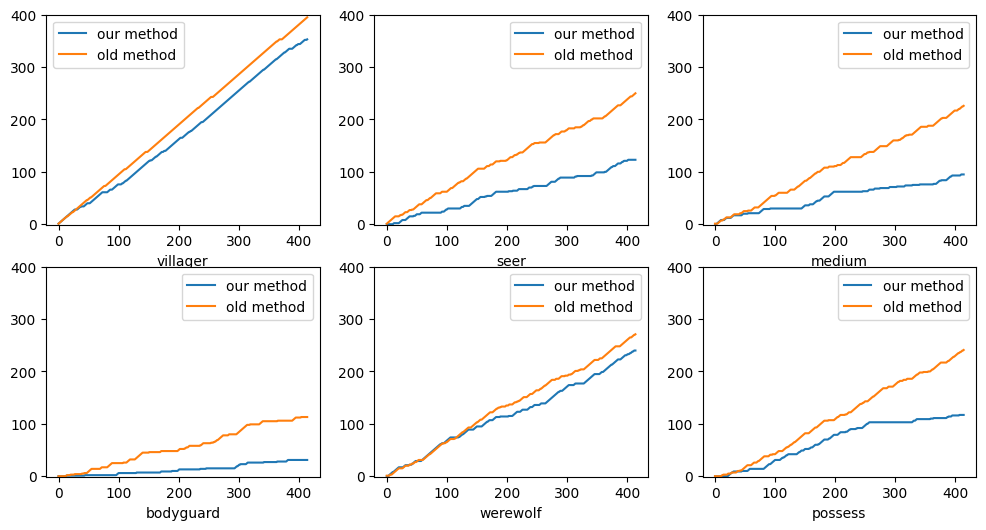

In [14]:
c = onnx_data[0].shape[0]
roles = ["villager", "seer", "medium", "bodyguard", "werewolf", "possess"]
plt.figure(figsize=(12, 6)) # 4*3 3*2
# plt.suptitle("Figure 1. Accumulated number of correct predections for days in 100 games")
plt.ylabel("Number of days of correct prediction")
for i in range(c):
    plt.subplot(2,3, i+1)
    # print(i%3+1,1+int(i/3), i+1)
    plt.plot([*range(onnx_data.shape[0])], onnx_data[:,i], label='our method')
    plt.plot([*range(onnx_data.shape[0])],prob_data[:,i], label='old method')
    plt.ylim(-1, 400)
    plt.xlabel(f"{roles[i]}")
    plt.legend()
plt.savefig("output.png")